## Visualizing single cell examples for pooled data
- Inputs are:
  - REQUIRED:
    -  **Input_gene_or_guide** - (str), it can be a string of gene symbol or guide (20 chars)
        - e.g., 'KRT28' or 'GTTGAAGAGCTAGATCAACG'
    -  **batch_name** - (str) batch name
        - e.g., '20200805_A549_WG_Screen' 
    - **rootDir** - image, metadata and overlays address is following the structure of dirs in the s3 bucket so we need to fix the root directory and everything else is being formed accroding to the s3 bucket structure 
        - e.g., '/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'
  - OPTIONAL:
    -  **n_cells** - (int), number of single cells to be visualized, it is ignored if cell_selection_method is geometric_median
    -  **box_size** - (int), size of box in pixels for cropping a cell    
    -  **channels** - (list), list of channels you want to plot
        - e.g., ['DNA','Mito','Phalloidin','WGA','ER','Outline'] 
    -  **cell_selection_method** - (str) can be one of the following methods
        - random - generate n randomly selected cells
        - representative - clusters the data and sample from the "closest to mean cluster"
        - geometric_median - plots single sample than is the geometric median of samples
        
        
###  Run time:

- For random cells (n_cells=6) -> ~ 3-4 mins
- For representative cells (For )  -> ~ 3-4 mins
- For geometric median (for calculate the gm from 1500 random subset of total cells) -> ~ 3 mins
  

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
from sklearn import preprocessing
import matplotlib.pyplot as plt
from singlecell.read import read_single_cell_sql
from singlecell.read import read_from_gallery

from singlecell.process import extract_single_cell_samples
# from singlecell.visualize import visualize_n_SingleCell
from singlecell.visualize import viz_pooled
from singlecell.preprocess.filter_out_edge_single_cells import edgeCellFilter

# import pooled_cell_painting_single_cell_visualization
import time
import gc
import os

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


In [3]:
??jupyter_black.load

### Set paths and params

In [107]:
input_gene = "ATP6V1A"
# input_gene_or_guide='GTTGAAGAGCTAGATCAACG'

# ########################## set batch to use
## CP186
batch='20200805_A549_WG_Screen';

## CP257
# batch = "20210422_6W_CP257"


########################## save generated images
resultsDir = "./results/"


########################## set directories/params when reading directly from cp gallery
rootDir = "cpg0021-periscope/broad/"

batch_multi_name_dict = {
    "20210422_6W_CP257": "HeLa",
    "20200805_A549_WG_Screen": "A549",
}


########################## set directories/params when reading from a mounted pooled-cp bucket
# rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'

# batch_multi_name_dict={'20210422_6W_CP257':'CP257-HeLa-WG',\
#                        '20200805_A549_WG_Screen':'CP186-A549-WG'}


######################### set alterative names used for path to each batch data which is set above
batch_alter_name = batch_multi_name_dict[batch]


######################### set path to single cell profiles
sc_files_dir_formatter = (
    "{0}/workspace/software/{1}"
    "/data/1.profiles/{2}/single_cell/single_cell_by_guide/"
)  # for pooled-cp-bucket

sc_files_dir_formatter = (
    "{0}workspace/profiles/{1}" "/single_cell_by_guide/"
)  # for cp gallery


sc_files_dir = sc_files_dir_formatter.format(rootDir, batch_alter_name, batch)


im_size = 5500  # hardcoded for now, TODO: create a dictionary if this number is different for 257 vs 186

#################### options for parameters to set
n_cells = 10
box_size = 100

# how we select cells which can be 'random','representative','geometric_median'
cell_selection_method = "representative"

channels = ["DNA", "Mito", "Phalloidin", "WGA", "ER"]


##################### read metadata and create the file name for input guide or gene
metadata_dir = (
    "/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/metadata/"
    + batch
    + "/"
)
metadata_orig = pd.read_csv(metadata_dir + "Barcodes.csv")


paths = {
    "root_dir": rootDir,
    "batch_folder": batch,
}


meta_cols = {
    "site": "Metadata_Foci_site_location",
    "well": "Metadata_Foci_well",
    "plate": "Metadata_Foci_plate",
}

viz_cols = {
    "center_indicator_columns_x_y": [
        "Cells_AreaShape_Center_X",
        "Cells_AreaShape_Center_Y",
    ],
    "image_path_column_prefix": "PathName_Corr",
    "image_name_column_prefix": "FileName_Corr",
}

fix_paths_params = {
    "paths": paths,
    "meta_cols": meta_cols,
    "viz_cols": viz_cols,
}

In [111]:
def custom_create_image_path_cols(params, df_p_s):
    """
    The following columns are needed for generation of single cell images,\
    if you already have it just modify the config file,
    if not you have to generate them
    """

    paths = params["paths"]
    meta_cols = params["meta_cols"]
    viz_cols = params["viz_cols"]

    for ch in channels:
        df_p_s["PathName_Corr" + ch] = (
            paths["root_dir"]
            + "images/"
            + paths["batch_folder"]
            + "/images_corrected_cropped/"
            + df_p_s[meta_cols["plate"]]
            + "_"
            + df_p_s[meta_cols["well"]]
            + "/Corr"
            + ch
        )

        df_p_s["FileName_Corr" + ch] = (
            "Corr"
            + ch
            + "_"
            + "Site_"
            + df_p_s[meta_cols["site"]].astype(str)
            + ".tiff"
        )

    df_p_s["Path_Outlines"] = (
        paths["root_dir"]
        + "workspace/analysis/"
        + batch
        + "/"
        + df_p_s[meta_cols["plate"]]
        + "-"
        + df_p_s[meta_cols["well"]]
        + "-"
        + df_p_s[meta_cols["site"]].astype(str)
        + "/"
        + "CorrDNA_Site_"
        + df_p_s[meta_cols["site"]].astype(str)
        + "_Overlay.png"
    )

    return df_p_s

In [110]:
df_p_s["Path_Outlines"].values[0]

'cpg0021-periscope/broad/workspace/analysis/20210422_6W_CP257/CP257A-Well5-18/CorrDNA_Site_18_Overlay.png'

In [124]:
lst_2gen = ["ATP6V1A","ATP6V1B2","ATP6V1G1","NUS1","TMTC3","DPM1","SAMM50","TOMM22","TOMM20","RIMS1","ACTN4",\
"WDR1","POLD2","POLE","POLD4"]
# NUS1

lst_2gen=["nontargeting"]
nt_guides=['TCCCTGCATTCATGGTTTTA',\
'ACCCATGAGTTAAGTTTTCT',\
'TTATATGGTTTTAAACGGCT',\
'CAGTCGTTTCTATGGGATCT',\
'TTCGCACGATTGCACCTTGG',\
'ATAAGCCACACTACCCGCCT',\
'ACTATCATGGCACCCAATTG',\
'GACTGAAATCCAAGGACTGT',\
'ATGTCTAGACCTAATCGTTT',\
'GTAAACTTTGTCTGGAGTAT']

In [128]:
gene_guids_ls.index(nt_guides[2])

1045

In [101]:
sc_files_dir+ batch+ "_single_cell_normalized_ALLBATCHES__"+ gi+ "_"+ input_gene+ ".csv.gz"

'cpg0021-periscope/broad/workspace/profiles/A549/single_cell_by_guide/20200805_A549_WG_Screen_single_cell_normalized_ALLBATCHES__TGACTGCTGATATCCGACAA_ATP6V1A.csv.gz'

In [104]:
ls /home/ubuntu/gallery/cpg0021-periscope/broad/workspace/profiles/A549/

20200805_A549_WG_Screen_gene_ALLBATCHES___CP186A___ALLWELLS.csv.gz*
20200805_A549_WG_Screen_gene_ALLBATCHES___CP186B___ALLWELLS.csv.gz*
20200805_A549_WG_Screen_gene_ALLBATCHES___CP186C___ALLWELLS.csv.gz*
20200805_A549_WG_Screen_gene_ALLBATCHES___CP186D___ALLWELLS.csv.gz*
20200805_A549_WG_Screen_gene_ALLBATCHES___CP186E___ALLWELLS.csv.gz*
20200805_A549_WG_Screen_gene_ALLBATCHES___CP186F___ALLWELLS.csv.gz*
20200805_A549_WG_Screen_gene_ALLBATCHES___CP186G___ALLWELLS.csv.gz*
20200805_A549_WG_Screen_gene_ALLBATCHES___CP186H___ALLWELLS.csv.gz*
20200805_A549_WG_Screen_gene_ALLBATCHES___CP186N___ALLWELLS.csv.gz*
20200805_A549_WG_Screen_gene_normalized_ALLBATCHES___CP186A___ALLWELLS.csv.gz*
20200805_A549_WG_Screen_gene_normalized_ALLBATCHES___CP186B___ALLWELLS.csv.gz*
20200805_A549_WG_Screen_gene_normalized_ALLBATCHES___CP186C___ALLWELLS.csv.gz*
20200805_A549_WG_Screen_gene_normalized_ALLBATCHES___CP186D___ALLWELLS.csv.gz*
20200805_A549_WG_Screen_gene_normalized_ALLBATCHES___CP186E___ALLWELLS.c

## Visualize single cells for the input gene of guide
- Read from gallery

cp_features: 3733
cols2remove_manyNulls ['Nuclei_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_MeanIntensityEdge_MaskedScores_IntValues', 'Cytoplasm_AreaShape_NormalizedMoment_0_0', 'Cells_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_StdIntensityEdge_MaskedScores_IntValues', 'Nuclei_AreaShape_NormalizedMoment_0_0', 'Cytoplasm_AreaShape_NormalizedMoment_0_1', 'Cells_Intensity_MassDisplacement_WellEdgeDistance', 'Cells_AreaShape_NormalizedMoment_0_1', 'Cytoplasm_AreaShape_NormalizedMoment_1_0', 'Cells_AreaShape_NormalizedMoment_0_0', 'Nuclei_AreaShape_NormalizedMoment_0_1']
cols2remove_lowVars ['Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_3of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_Overflow', 'Nuclei_AreaShape_EulerNumber', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of16', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_Ove

<IPython.core.display.Javascript object>


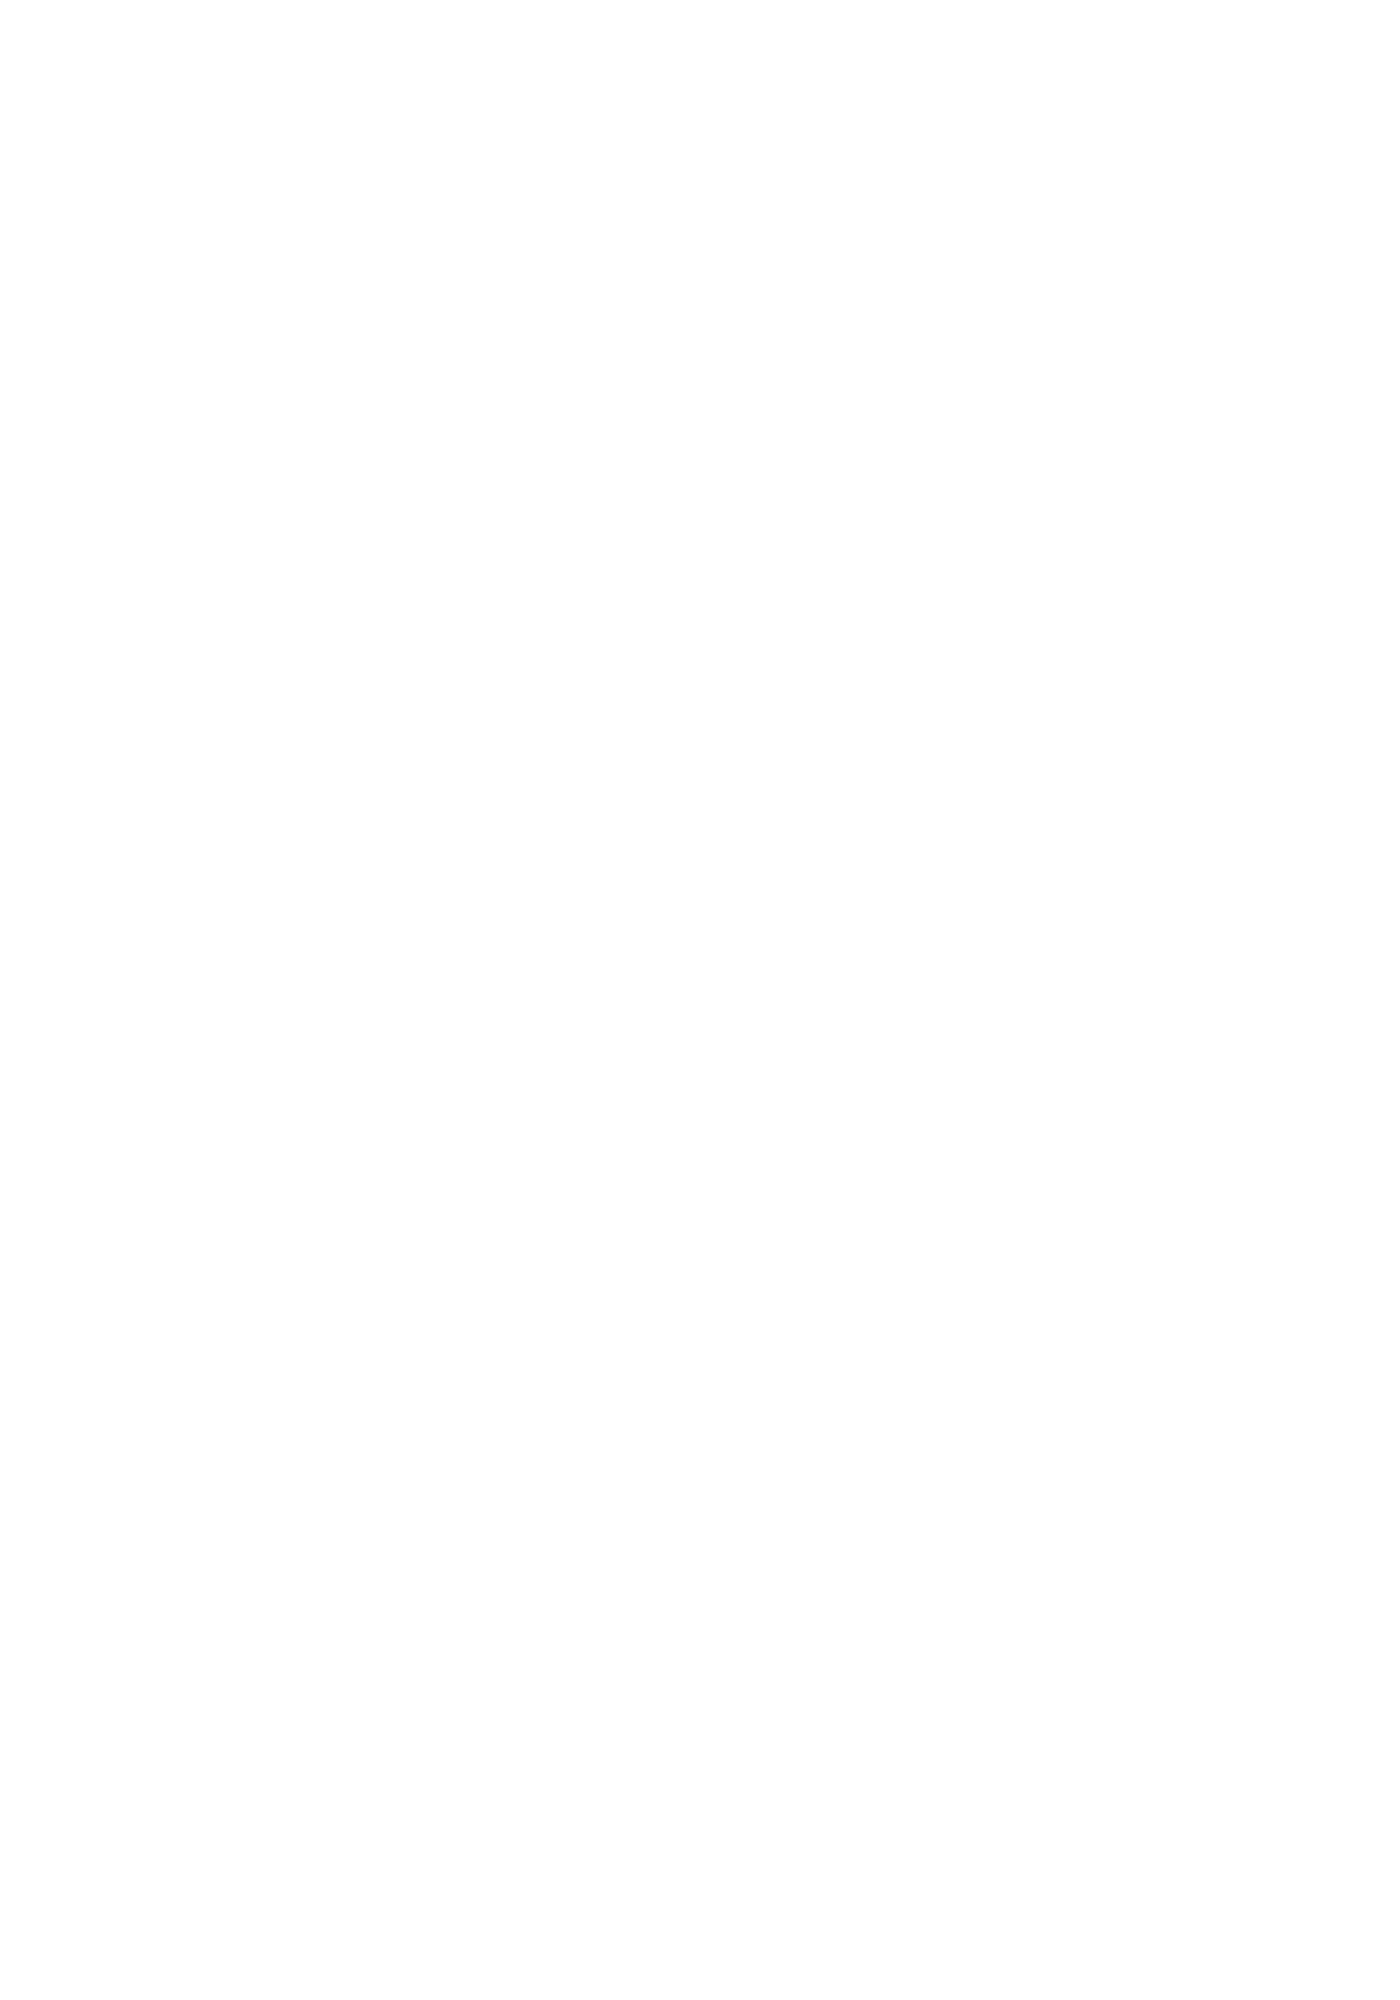

nontargeting_representative
cp_features: 3733
cols2remove_manyNulls ['Nuclei_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_MeanIntensityEdge_MaskedScores_IntValues', 'Cytoplasm_AreaShape_NormalizedMoment_0_0', 'Cells_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_StdIntensityEdge_MaskedScores_IntValues', 'Nuclei_AreaShape_NormalizedMoment_0_0', 'Cytoplasm_AreaShape_NormalizedMoment_0_1', 'Cells_Intensity_MassDisplacement_WellEdgeDistance', 'Cells_AreaShape_NormalizedMoment_0_1', 'Cytoplasm_AreaShape_NormalizedMoment_1_0', 'Cells_AreaShape_NormalizedMoment_0_0', 'Nuclei_AreaShape_NormalizedMoment_0_1']
cols2remove_lowVars ['Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_3of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_Overflow', 'Nuclei_AreaShape_EulerNumber', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of16', 'Cytoplasm_RadialDistributio

<IPython.core.display.Javascript object>


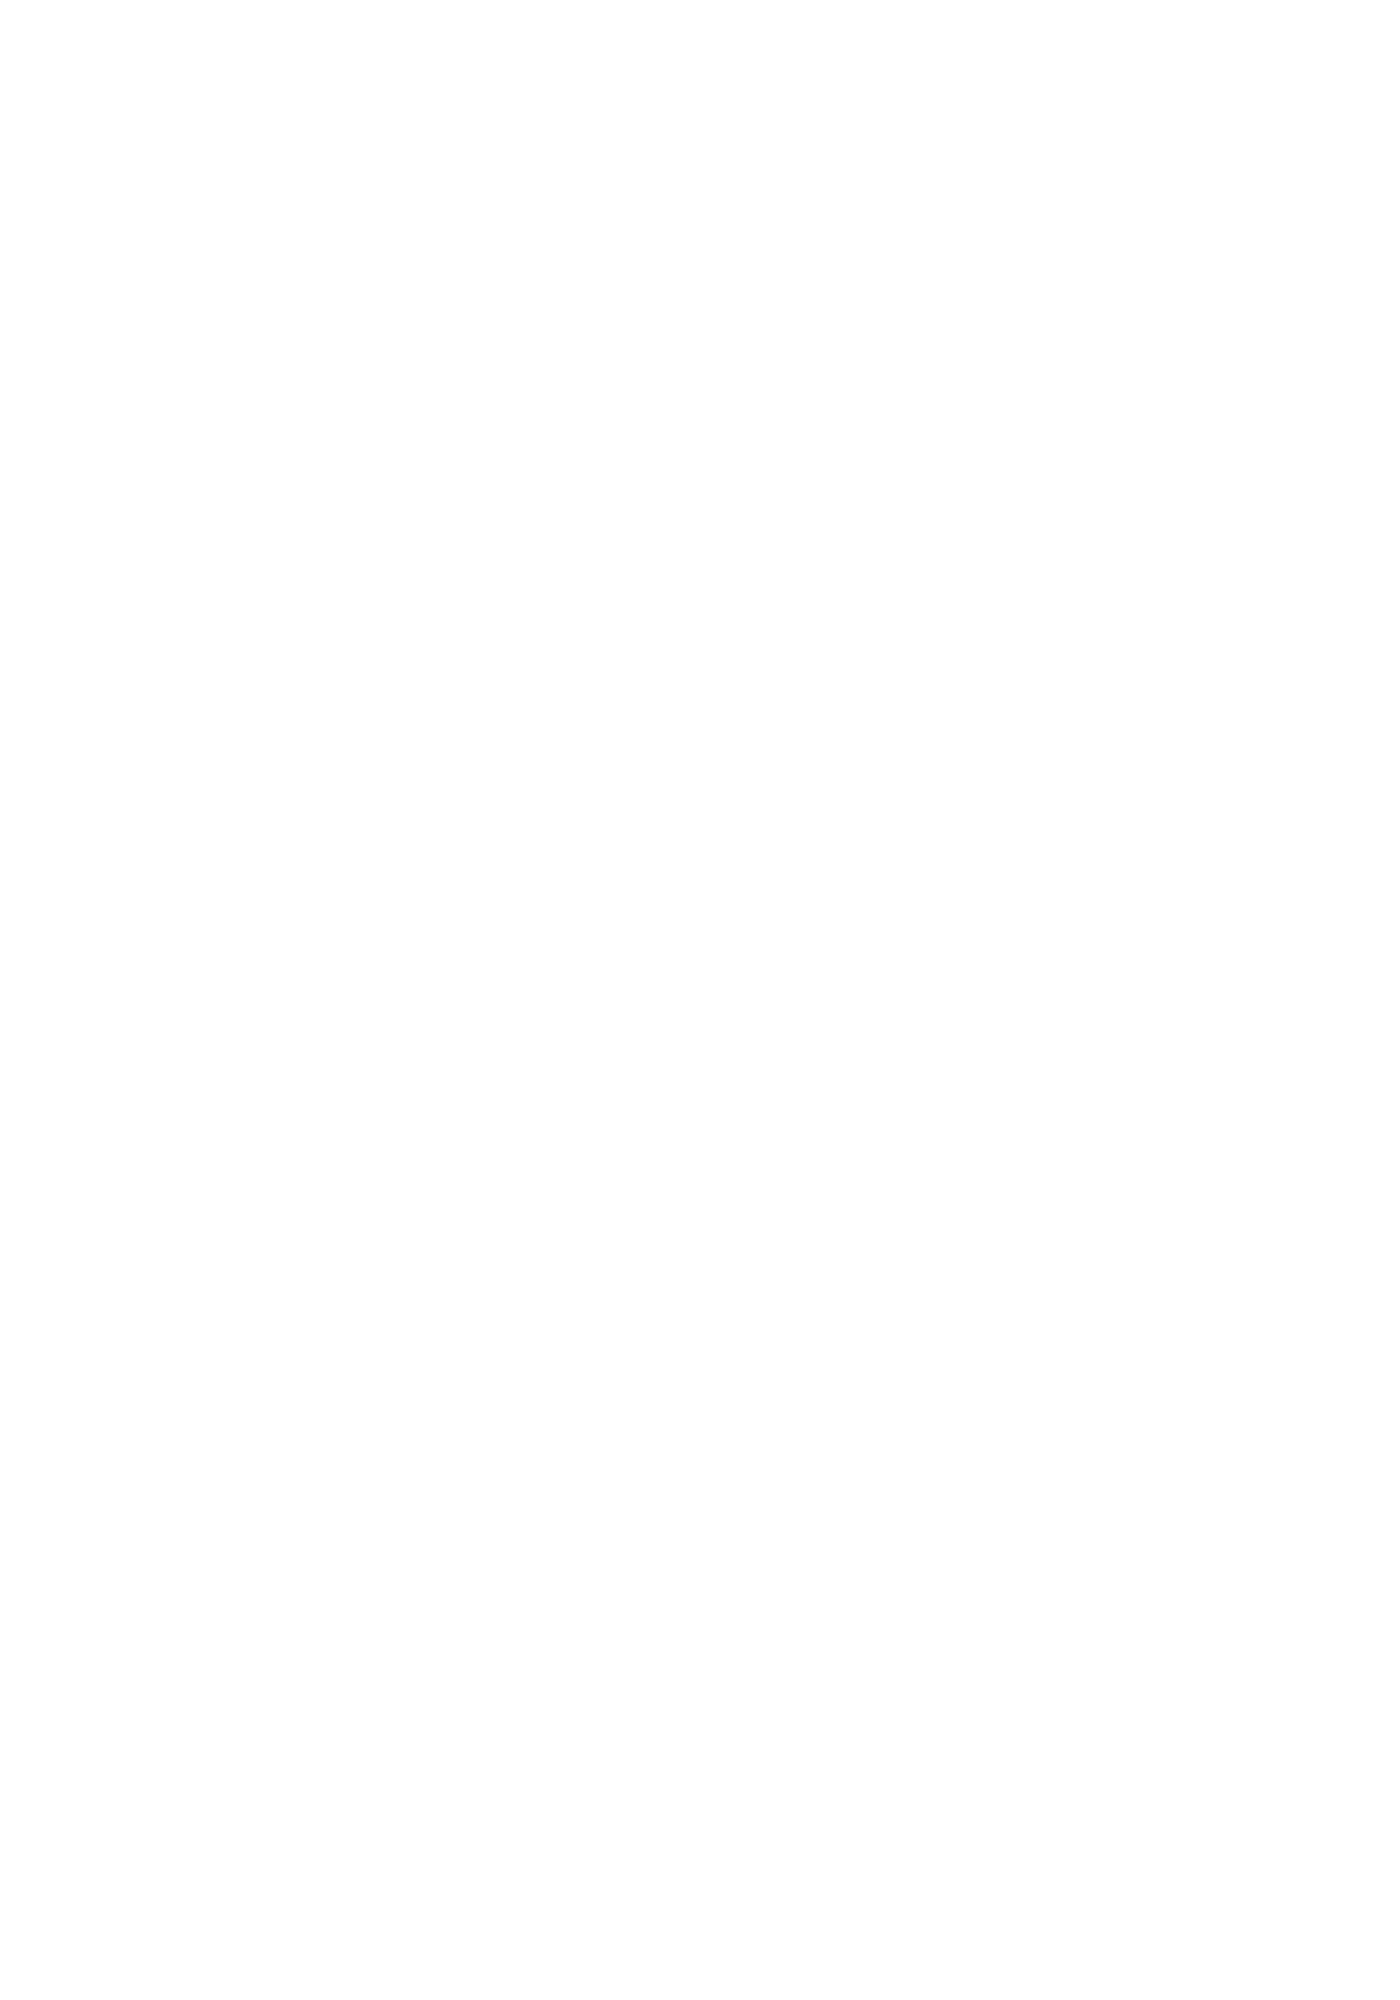

nontargeting_representative
cp_features: 3733
cols2remove_manyNulls ['Nuclei_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_MeanIntensityEdge_MaskedScores_IntValues', 'Cytoplasm_AreaShape_NormalizedMoment_0_0', 'Cells_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_StdIntensityEdge_MaskedScores_IntValues', 'Cells_Correlation_K_DAPI_Painting_Mito', 'Cells_Correlation_K_Mito_DAPI_Painting', 'Cells_Correlation_Overlap_DAPI_Painting_Mito', 'Nuclei_AreaShape_NormalizedMoment_0_0', 'Cytoplasm_AreaShape_NormalizedMoment_0_1', 'Cells_Intensity_MassDisplacement_WellEdgeDistance', 'Cells_AreaShape_NormalizedMoment_0_1', 'Cytoplasm_AreaShape_NormalizedMoment_1_0', 'Cells_AreaShape_NormalizedMoment_0_0', 'Nuclei_AreaShape_NormalizedMoment_0_1']
cols2remove_lowVars ['Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_3of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_Overflow', 'Nuclei_AreaShape_EulerNumber', 'Cytoplasm_Radial

<IPython.core.display.Javascript object>


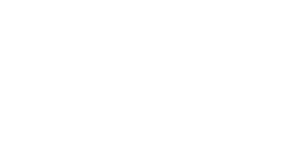

nontargeting_representative
cp_features: 3733
cols2remove_manyNulls ['Nuclei_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_MeanIntensityEdge_MaskedScores_IntValues', 'Cytoplasm_AreaShape_NormalizedMoment_0_0', 'Cells_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_StdIntensityEdge_MaskedScores_IntValues', 'Nuclei_AreaShape_NormalizedMoment_0_0', 'Cytoplasm_AreaShape_NormalizedMoment_0_1', 'Cells_Intensity_MassDisplacement_WellEdgeDistance', 'Cells_AreaShape_NormalizedMoment_0_1', 'Cytoplasm_AreaShape_NormalizedMoment_1_0', 'Cells_AreaShape_NormalizedMoment_0_0', 'Nuclei_AreaShape_NormalizedMoment_0_1']
cols2remove_lowVars ['Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_3of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_Overflow', 'Nuclei_AreaShape_EulerNumber', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of16', 'Cytoplasm_RadialDistributio

<IPython.core.display.Javascript object>


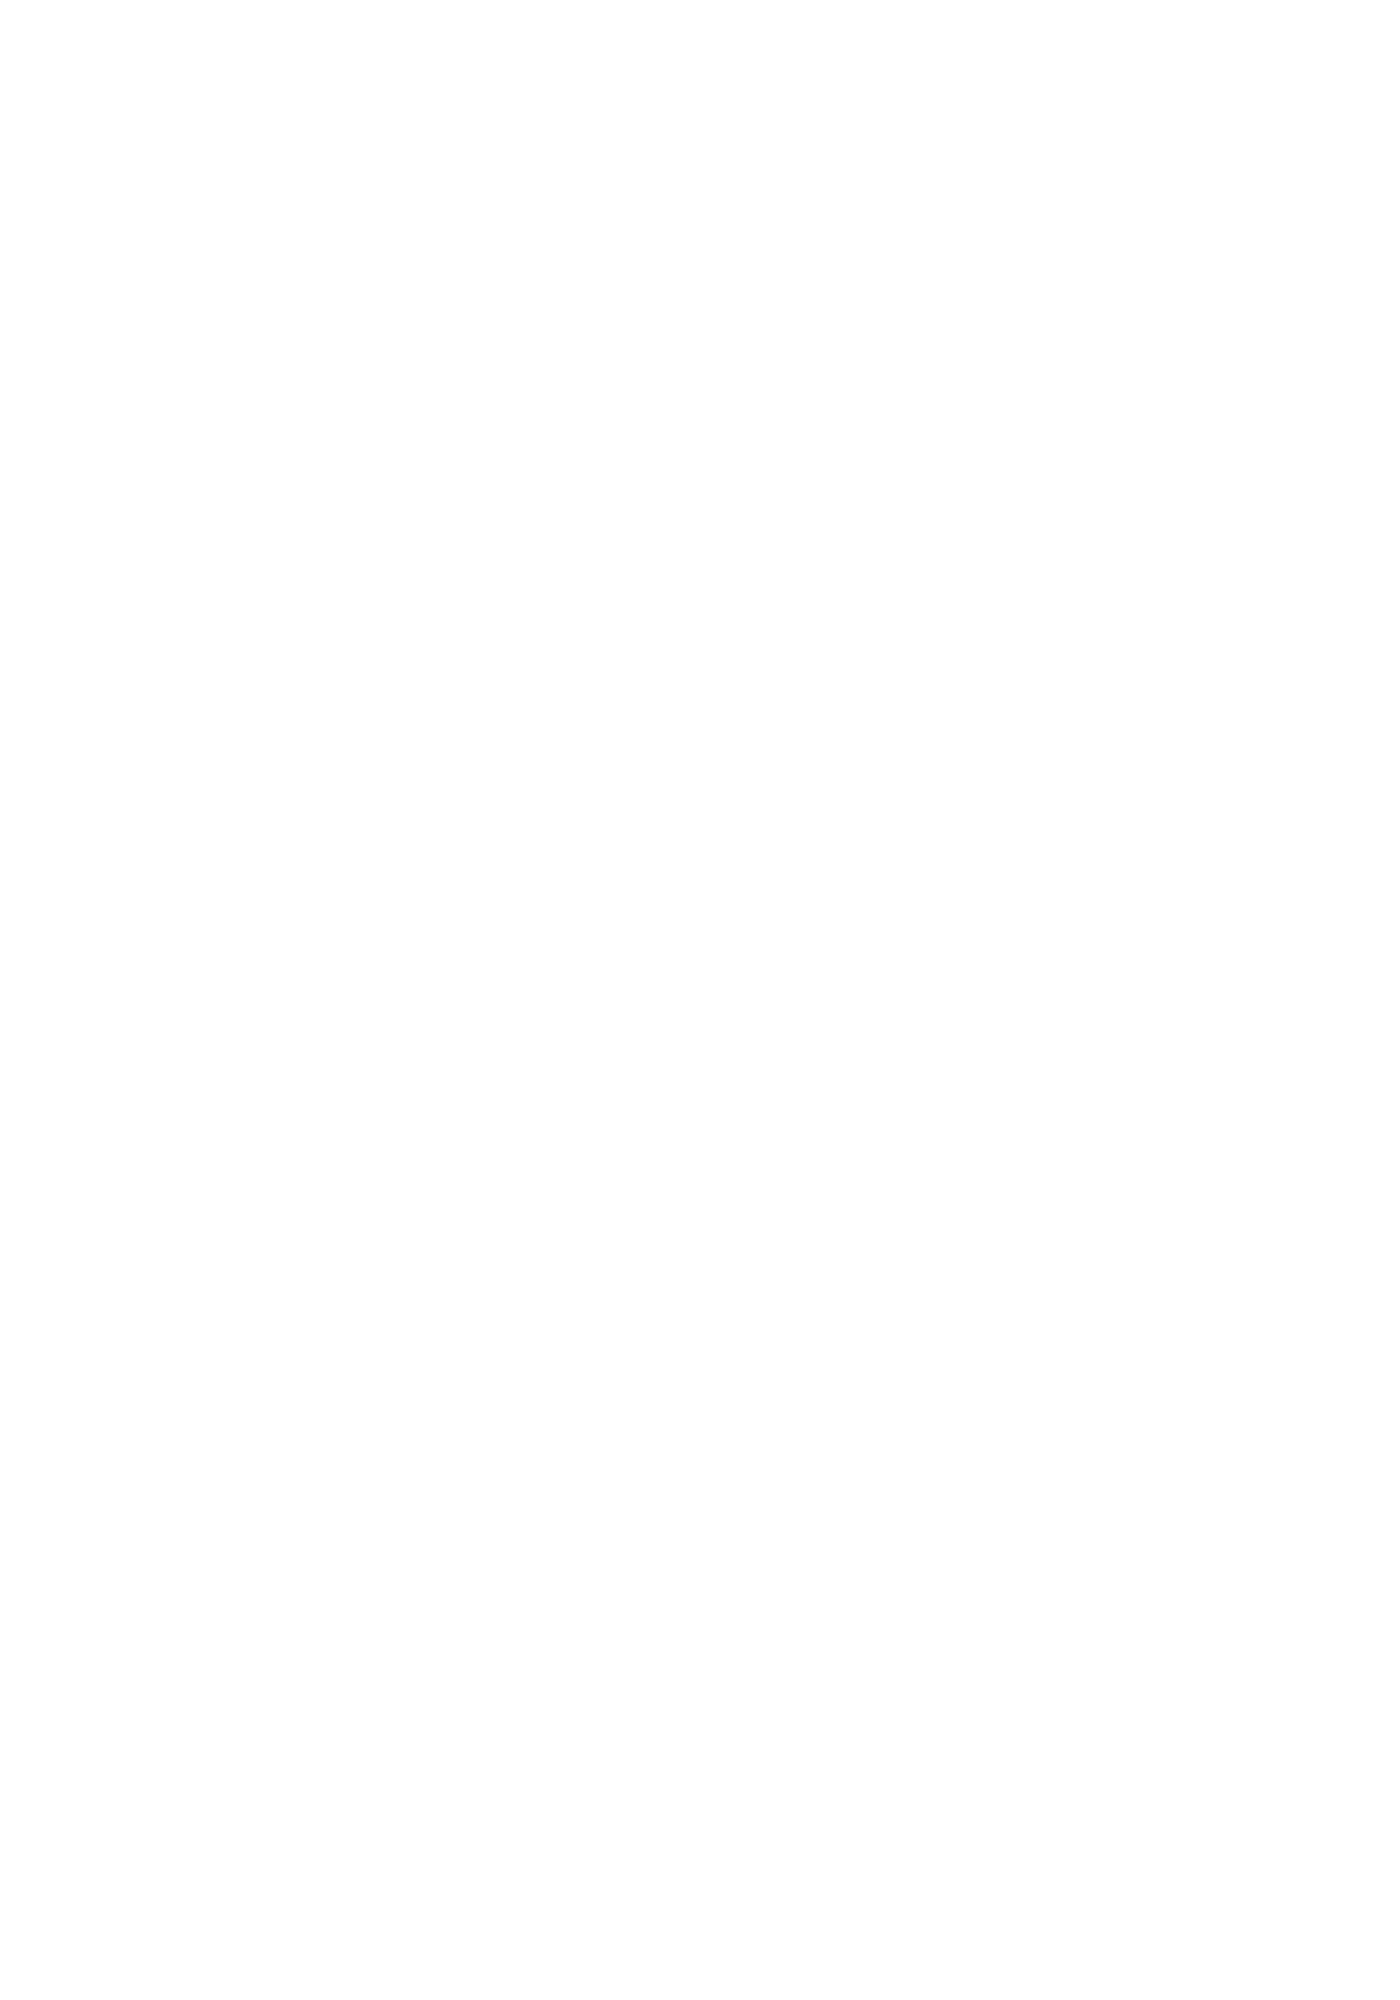

nontargeting_representative
cp_features: 3733
cols2remove_manyNulls ['Nuclei_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_MeanIntensityEdge_MaskedScores_IntValues', 'Cytoplasm_AreaShape_NormalizedMoment_0_0', 'Cells_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_StdIntensityEdge_MaskedScores_IntValues', 'Nuclei_AreaShape_NormalizedMoment_0_0', 'Cytoplasm_AreaShape_NormalizedMoment_0_1', 'Cells_Intensity_MassDisplacement_WellEdgeDistance', 'Cells_AreaShape_NormalizedMoment_0_1', 'Cytoplasm_AreaShape_NormalizedMoment_1_0', 'Cells_AreaShape_NormalizedMoment_0_0', 'Nuclei_AreaShape_NormalizedMoment_0_1']
cols2remove_lowVars ['Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_3of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_Overflow', 'Nuclei_AreaShape_EulerNumber', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of16', 'Cytoplasm_RadialDistributio

<IPython.core.display.Javascript object>


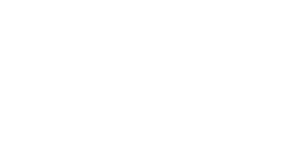

nontargeting_representative
cp_features: 3733
cols2remove_manyNulls ['Nuclei_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_MeanIntensityEdge_MaskedScores_IntValues', 'Cytoplasm_AreaShape_NormalizedMoment_0_0', 'Cells_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_StdIntensityEdge_MaskedScores_IntValues', 'Nuclei_AreaShape_NormalizedMoment_0_0', 'Cytoplasm_AreaShape_NormalizedMoment_0_1', 'Cells_Intensity_MassDisplacement_WellEdgeDistance', 'Cells_AreaShape_NormalizedMoment_0_1', 'Cytoplasm_AreaShape_NormalizedMoment_1_0', 'Cells_AreaShape_NormalizedMoment_0_0', 'Nuclei_AreaShape_NormalizedMoment_0_1']
cols2remove_lowVars ['Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_3of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_Overflow', 'Nuclei_AreaShape_EulerNumber', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of16', 'Cytoplasm_RadialDistributio

<IPython.core.display.Javascript object>


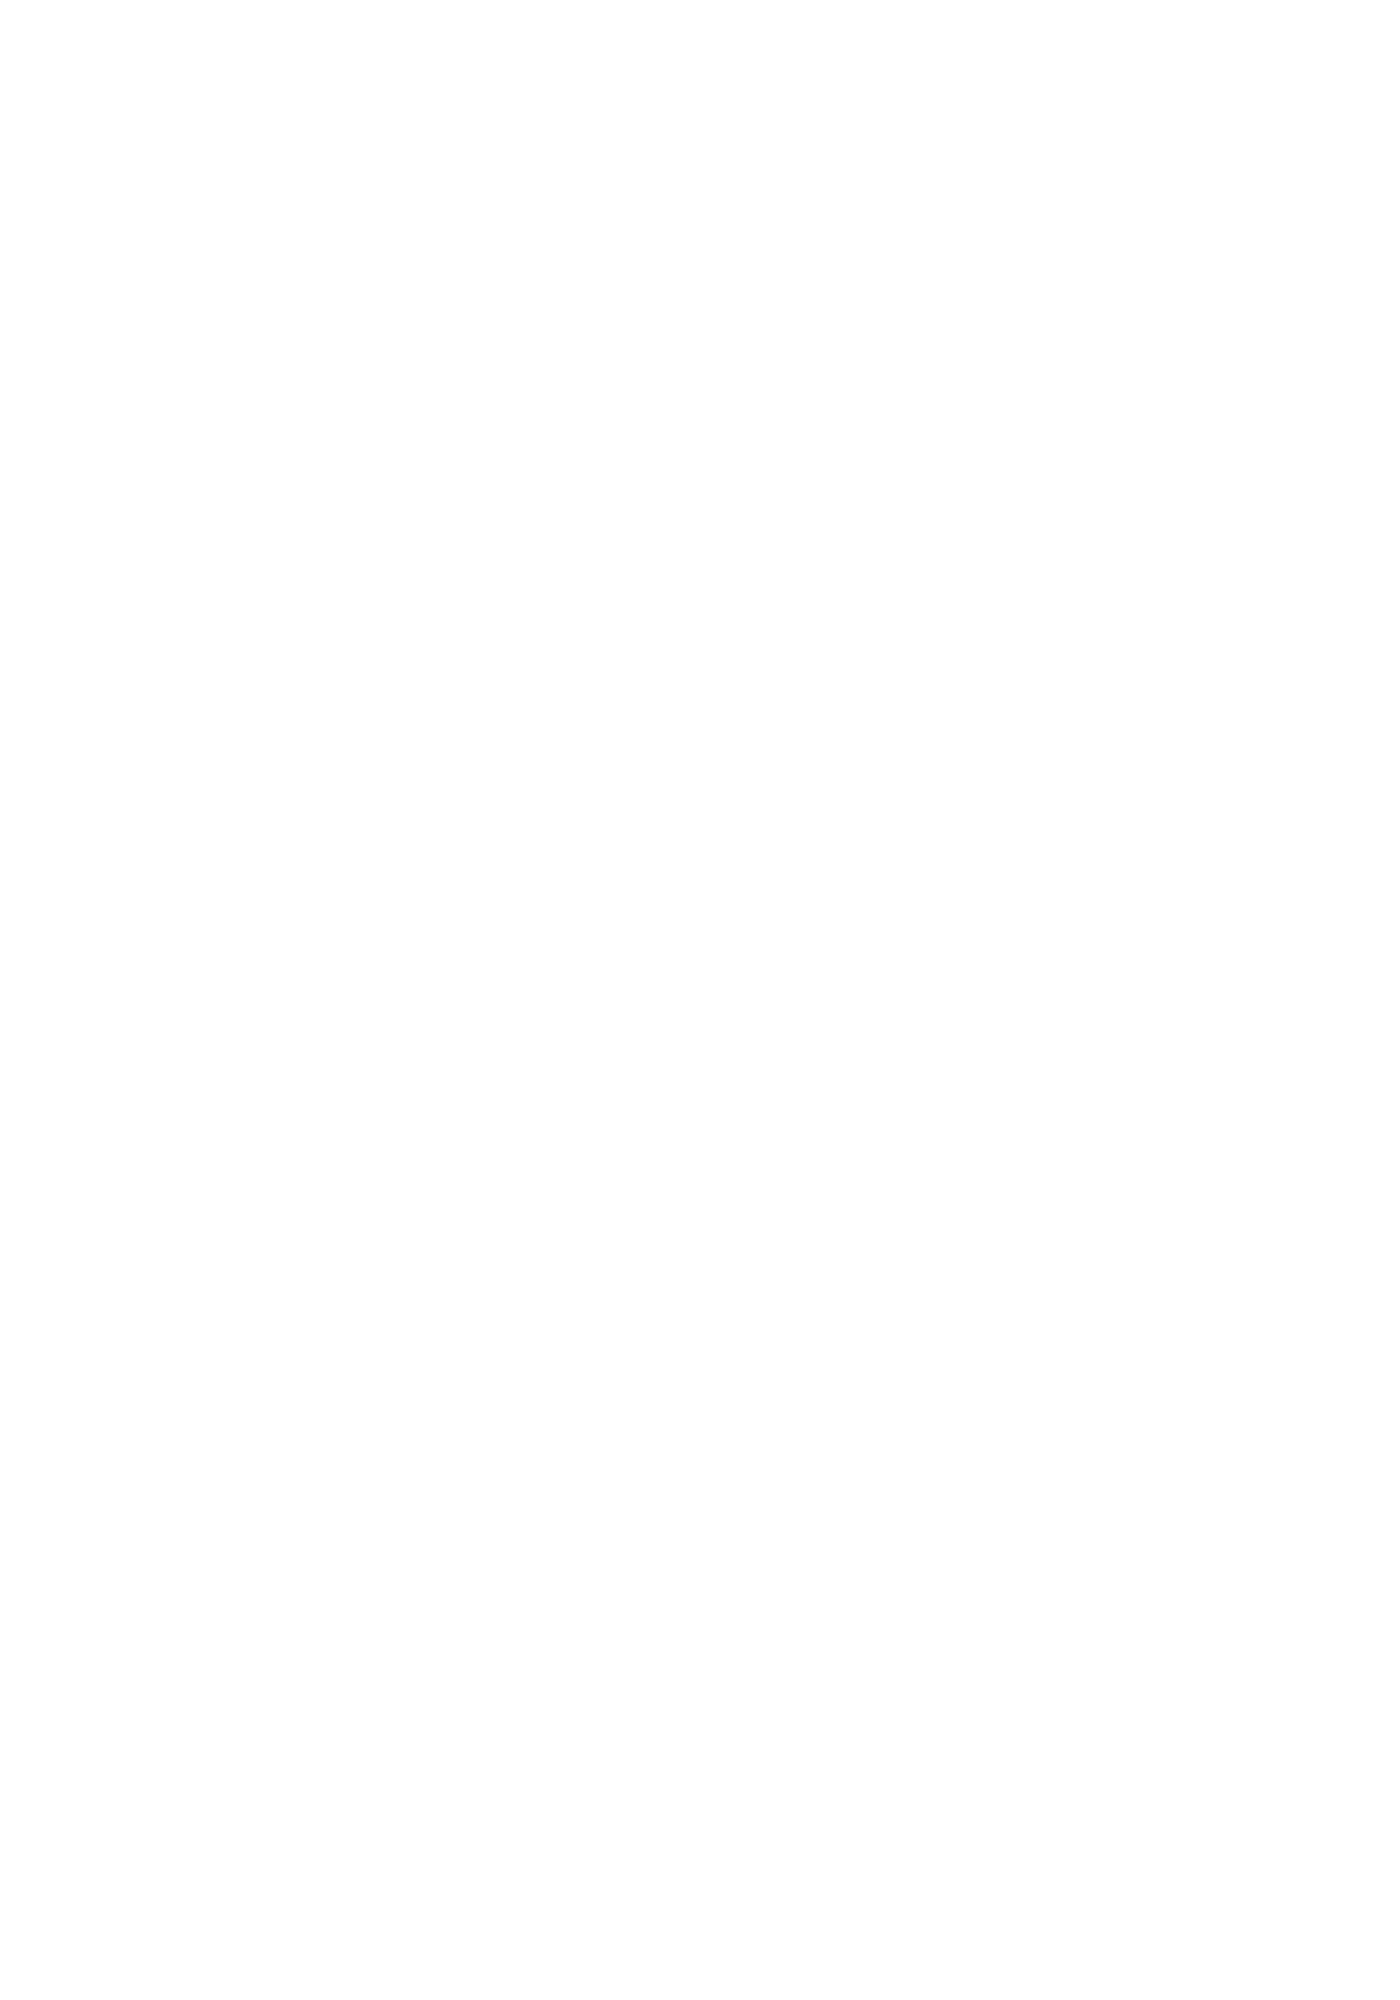

nontargeting_representative
cp_features: 3733
cols2remove_manyNulls ['Nuclei_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_MeanIntensityEdge_MaskedScores_IntValues', 'Cytoplasm_AreaShape_NormalizedMoment_0_0', 'Cells_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_StdIntensityEdge_MaskedScores_IntValues', 'Nuclei_AreaShape_NormalizedMoment_0_0', 'Cytoplasm_AreaShape_NormalizedMoment_0_1', 'Cells_Intensity_MassDisplacement_WellEdgeDistance', 'Cells_AreaShape_NormalizedMoment_0_1', 'Cytoplasm_AreaShape_NormalizedMoment_1_0', 'Cells_AreaShape_NormalizedMoment_0_0', 'Nuclei_AreaShape_NormalizedMoment_0_1']
cols2remove_lowVars ['Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_3of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_Overflow', 'Nuclei_AreaShape_EulerNumber', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of16', 'Cytoplasm_RadialDistributio

<IPython.core.display.Javascript object>


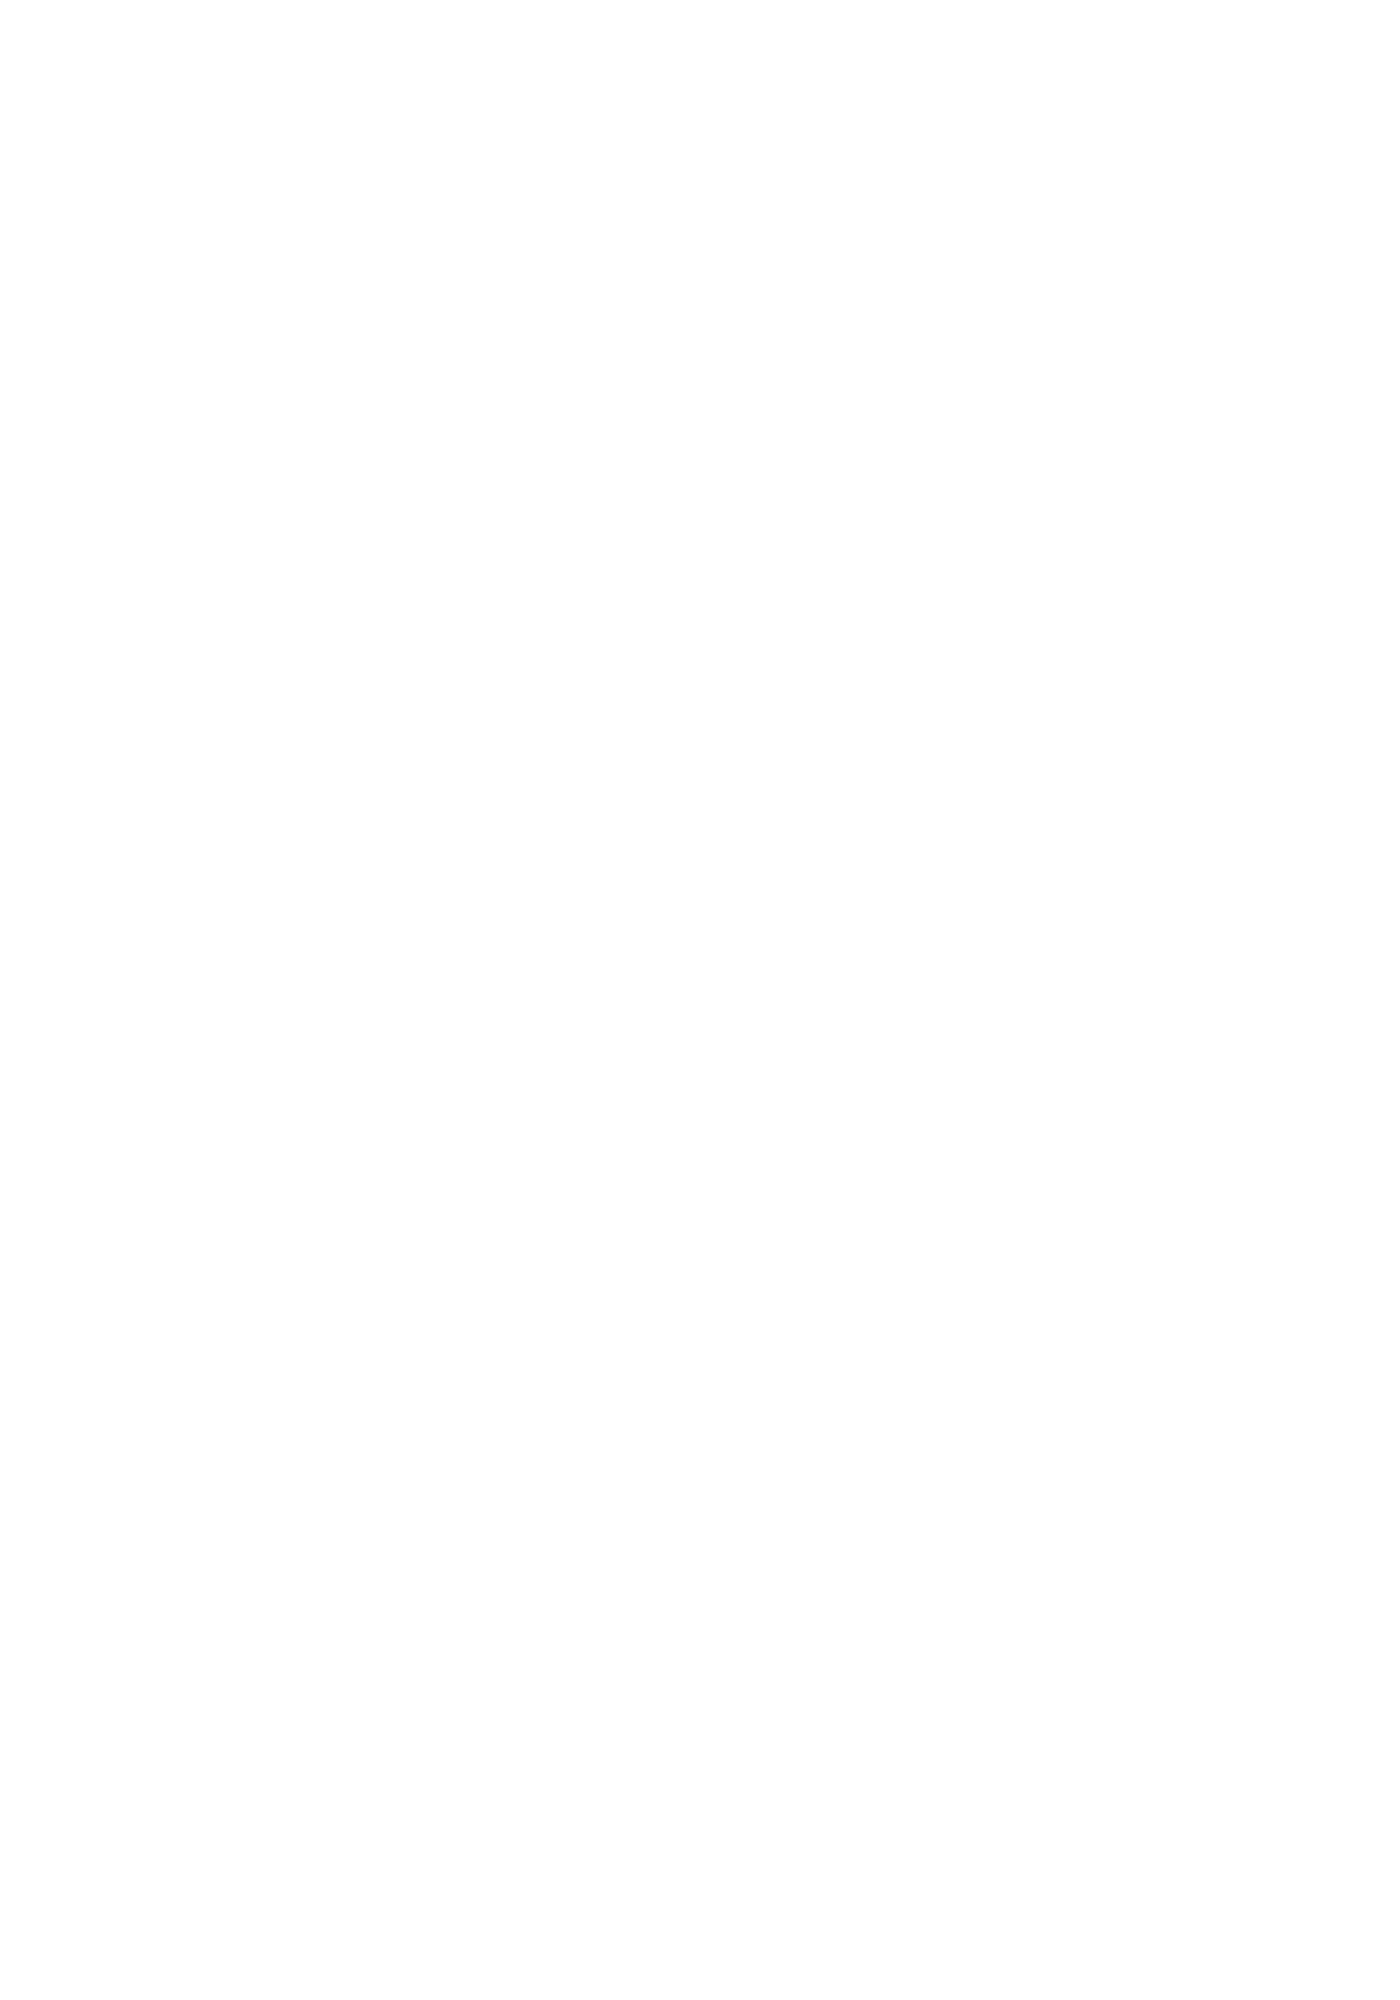

nontargeting_representative
cp_features: 3733
cols2remove_manyNulls ['Nuclei_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_MeanIntensityEdge_MaskedScores_IntValues', 'Cytoplasm_AreaShape_NormalizedMoment_0_0', 'Cells_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_StdIntensityEdge_MaskedScores_IntValues', 'Nuclei_AreaShape_NormalizedMoment_0_0', 'Cytoplasm_AreaShape_NormalizedMoment_0_1', 'Cells_Intensity_MassDisplacement_WellEdgeDistance', 'Cells_AreaShape_NormalizedMoment_0_1', 'Cytoplasm_AreaShape_NormalizedMoment_1_0', 'Cells_AreaShape_NormalizedMoment_0_0', 'Nuclei_AreaShape_NormalizedMoment_0_1']
cols2remove_lowVars ['Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_3of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_Overflow', 'Nuclei_AreaShape_EulerNumber', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of16', 'Cytoplasm_RadialDistributio

<IPython.core.display.Javascript object>


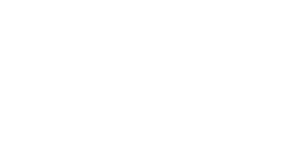

nontargeting_representative
cp_features: 3733
cols2remove_manyNulls ['Nuclei_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_MeanIntensityEdge_MaskedScores_IntValues', 'Cytoplasm_AreaShape_NormalizedMoment_0_0', 'Cells_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_StdIntensityEdge_MaskedScores_IntValues', 'Nuclei_AreaShape_NormalizedMoment_0_0', 'Cytoplasm_AreaShape_NormalizedMoment_0_1', 'Cells_Intensity_MassDisplacement_WellEdgeDistance', 'Cells_AreaShape_NormalizedMoment_0_1', 'Cytoplasm_AreaShape_NormalizedMoment_1_0', 'Cells_AreaShape_NormalizedMoment_0_0', 'Nuclei_AreaShape_NormalizedMoment_0_1']
cols2remove_lowVars ['Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_3of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_Overflow', 'Nuclei_AreaShape_EulerNumber', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of16', 'Cytoplasm_RadialDistributio

<IPython.core.display.Javascript object>


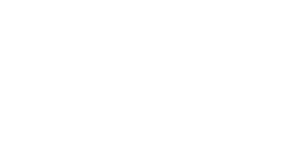

nontargeting_representative
cp_features: 3733
cols2remove_manyNulls ['Nuclei_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_MeanIntensityEdge_MaskedScores_IntValues', 'Cytoplasm_AreaShape_NormalizedMoment_0_0', 'Cells_AreaShape_NormalizedMoment_1_0', 'Cells_Intensity_StdIntensityEdge_MaskedScores_IntValues', 'Nuclei_AreaShape_NormalizedMoment_0_0', 'Cytoplasm_AreaShape_NormalizedMoment_0_1', 'Cells_Intensity_MassDisplacement_WellEdgeDistance', 'Cells_AreaShape_NormalizedMoment_0_1', 'Cytoplasm_AreaShape_NormalizedMoment_1_0', 'Cells_AreaShape_NormalizedMoment_0_0', 'Nuclei_AreaShape_NormalizedMoment_0_1']
cols2remove_lowVars ['Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_3of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_Overflow', 'Nuclei_AreaShape_EulerNumber', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of16', 'Cytoplasm_RadialDistributio

<IPython.core.display.Javascript object>


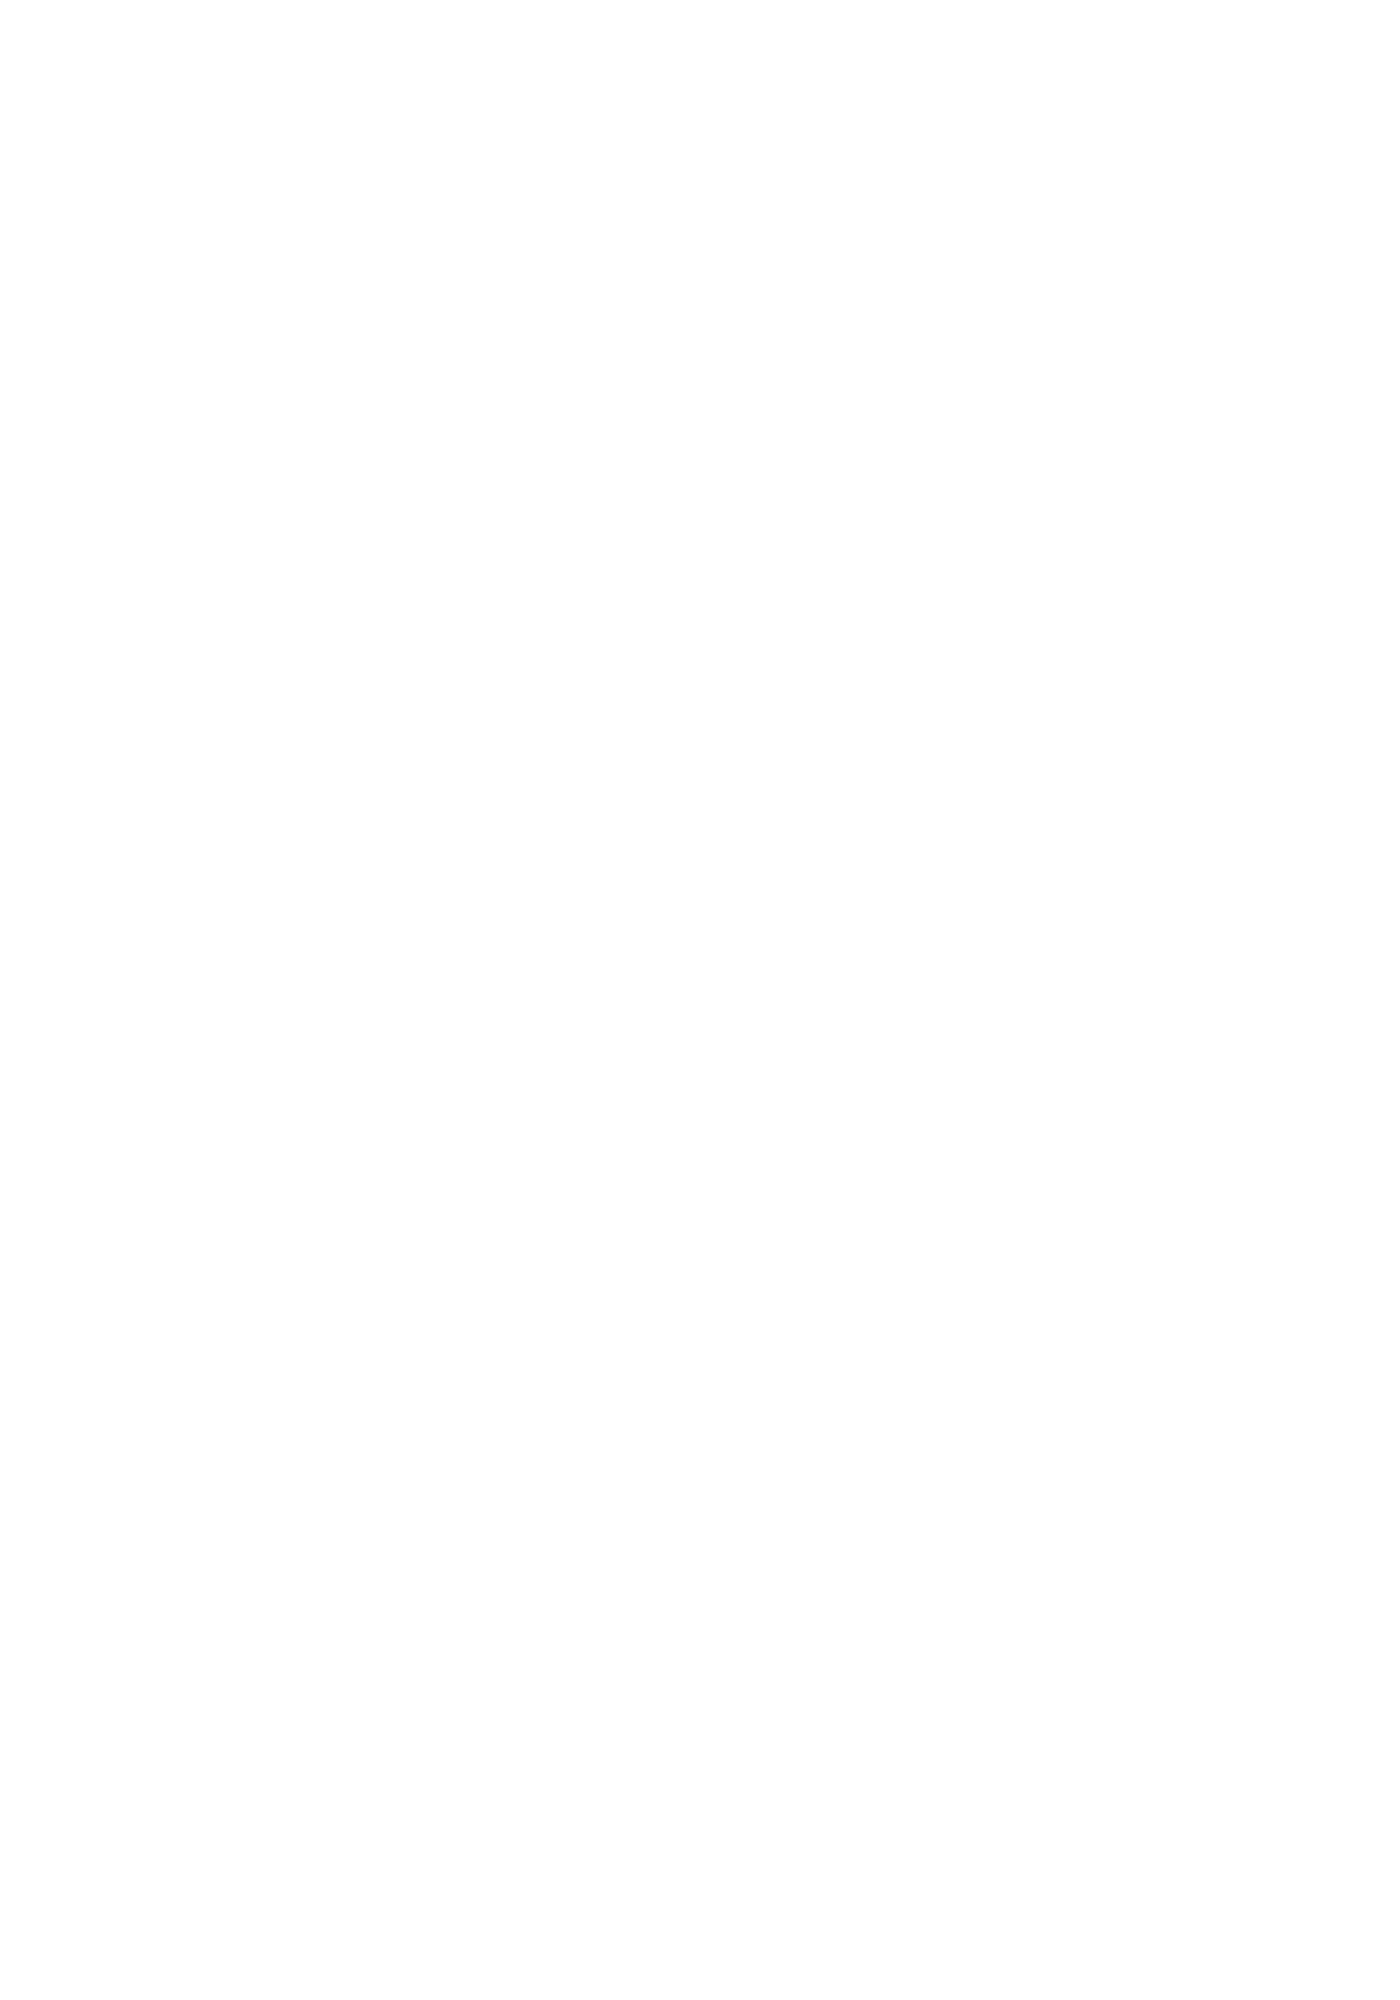

nontargeting_representative


In [129]:
resultsDir = "/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/20200805_A549_WG_Screen/paper_list/"
for input_gene in lst_2gen:
    #### get guides corresponding to the input gene by checking the barcode library reference table
    gene_guids_ls = metadata_orig[
        metadata_orig["gene_symbol"] == input_gene
    ].sgRNA.tolist()

    
    for gi in gene_guids_ls:

        df_p_s = read_from_gallery.read_csv_gzip(
            sc_files_dir
            + batch
            + "_single_cell_normalized_ALLBATCHES__"
            + gi
            + "_"
            + input_gene
            + ".csv.gz"
        )

        df_p_s = custom_create_image_path_cols(fix_paths_params, df_p_s)

        df_p_s["Nuclei_Location_Center_X"] = df_p_s["Cells_AreaShape_Center_X"]
        df_p_s["Nuclei_Location_Center_Y"] = df_p_s["Cells_AreaShape_Center_Y"]

        df_p_s, _ = edgeCellFilter(df_p_s, im_size, box_size / 2)

        if df_p_s.shape[0] > 0:
            (
                df_samples,
                cp_features_analysis,
            ) = extract_single_cell_samples.extract_single_cell_samples(
                df_p_s, n_cells, cell_selection_method
            )

            resdir = resultsDir + input_gene  # +'/'+gi.split('_')[-2]
            os.system("mkdir -p " + resdir)


            max_dist_of_neigh = 400
            neigh_center_ls = viz_pooled.extract_neighbor_cells_center(
                df_p_s,
                df_samples, max_dist_of_neigh
            )

            df_samples["label"] = (
                df_p_s["Metadata_Foci_well"]
                + "-"
                + df_p_s["Metadata_Foci_site_location"].astype(str)
            )        

            fig = viz_pooled.visualize_n_SingleCell_pooled(
                channels,
                df_samples,
                box_size,
                im_size,
                outline=True,
                color=True,
                title=input_gene + "_" + cell_selection_method,
                neigh_center_ls=neigh_center_ls,
            )
            fig.savefig(resdir + "/" + gi + ".png", dpi=500)
            plt.close('all')
    #         sc_fig = visualize_n_SingleCell.visualize_n_SingleCell(
    #             channels,
    #             df_samples,
    #             box_size,
    #             info_columns=y_labels,
    #             outline=True,
    #             color=True,
    #             title=cell_selection_method,
    #             compressed=True,
    #             compressed_im_size=1080,
    #         );

In [120]:
neigh_center_ls

[[[2105, 2148], [2666, 2814]],
 [[], []],
 [[4226], [1532]],
 [[774], [4636]],
 [[], []],
 [[], []],
 [[], []],
 [[4781], [3835]],
 [[], []],
 [[3219, 3158], [4710, 4711]]]

In [114]:
# neigh_center_ls
df_samples

,Metadata_Foci_Parent_Cells,Metadata_Foci_Cell_Quality_Index,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,Metadata_Foci_Barcode_MatchedTo_Score_mean,Metadata_Foci_Barcode_MatchedTo_Score_count,Metadata_Foci_cell_quality_method,Metadata_Foci_ImageNumber,Metadata_Foci_site,Metadata_Foci_plate,...,FileName_CorrPhalloidin,PathName_CorrWGA,FileName_CorrWGA,PathName_CorrER,FileName_CorrER,Path_Outlines,Nuclei_Location_Center_X,Nuclei_Location_Center_Y,clusterLabels,label
0,4333,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,8,simple,440,CP186D-Well2-75,CP186D,...,CorrPhalloidin_Site_75.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_75.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_75.tiff,cpg0021-periscope/broad/workspace/analysis/202...,5172.60,2654.50,0,Well3-27
1,2117,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,1,simple,439,CP186F-Well1-75,CP186F,...,CorrPhalloidin_Site_75.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_75.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_75.tiff,cpg0021-periscope/broad/workspace/analysis/202...,191.54,1675.10,0,Well5-39
2,522,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,1,simple,380,CP186F-Well2-66,CP186F,...,CorrPhalloidin_Site_66.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_66.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_66.tiff,cpg0021-periscope/broad/workspace/analysis/202...,4321.60,473.67,0,Well6-29
3,4934,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,1,simple,263,CP186C-Well5-48,CP186C,...,CorrPhalloidin_Site_48.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_48.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_48.tiff,cpg0021-periscope/broad/workspace/analysis/202...,2633.00,2618.40,0,Well5-48
4,189,2,POLD4,TGGCAGTACGGGCCCTGCAC,0.98810,7,simple,346,CP186F-Well4-60,CP186F,...,CorrPhalloidin_Site_60.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_60.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_60.tiff,cpg0021-periscope/broad/workspace/analysis/202...,511.98,289.17,0,Well1-88
5,7842,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,4,simple,249,CP186E-Well3-46,CP186E,...,CorrPhalloidin_Site_46.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_46.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_46.tiff,cpg0021-periscope/broad/workspace/analysis/202...,3817.60,3383.50,0,Well5-50
6,4484,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,2,simple,316,CP186D-Well4-56,CP186D,...,CorrPhalloidin_Site_56.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_56.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_56.tiff,cpg0021-periscope/broad/workspace/analysis/202...,4821.70,2618.20,0,Well2-75
7,6921,2,POLD4,TGGCAGTACGGGCCCTGCAC,0.95833,2,simple,320,CP186E-Well2-57,CP186E,...,CorrPhalloidin_Site_57.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_57.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_57.tiff,cpg0021-periscope/broad/workspace/analysis/202...,3578.80,3415.40,0,Well4-68
8,4137,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,1,simple,123,CP186B-Well3-27,CP186B,...,CorrPhalloidin_Site_27.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_27.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_27.tiff,cpg0021-periscope/broad/workspace/analysis/202...,4232.90,2882.40,0,Well4-68
9,6537,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,2,simple,410,CP186D-Well2-70,CP186D,...,CorrPhalloidin_Site_70.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_70.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_70.tiff,cpg0021-periscope/broad/workspace/analysis/202...,2237.20,4457.30,0,Well4-24


In [115]:
df_p_s

,Metadata_Foci_Parent_Cells,Metadata_Foci_Cell_Quality_Index,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,Metadata_Foci_Barcode_MatchedTo_Score_mean,Metadata_Foci_Barcode_MatchedTo_Score_count,Metadata_Foci_cell_quality_method,Metadata_Foci_ImageNumber,Metadata_Foci_site,Metadata_Foci_plate,...,FileName_CorrMito,PathName_CorrPhalloidin,FileName_CorrPhalloidin,PathName_CorrWGA,FileName_CorrWGA,PathName_CorrER,FileName_CorrER,Path_Outlines,Nuclei_Location_Center_X,Nuclei_Location_Center_Y
0,4137,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,1,simple,123,CP186B-Well3-27,CP186B,...,CorrMito_Site_27.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrPhalloidin_Site_27.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_27.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_27.tiff,cpg0021-periscope/broad/workspace/analysis/202...,4232.90,2882.40
1,1063,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,1,simple,203,CP186C-Well5-39,CP186C,...,CorrMito_Site_39.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrPhalloidin_Site_39.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_39.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_39.tiff,cpg0021-periscope/broad/workspace/analysis/202...,1321.30,619.81
2,3565,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,2,simple,138,CP186C-Well6-29,CP186C,...,CorrMito_Site_29.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrPhalloidin_Site_29.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_29.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_29.tiff,cpg0021-periscope/broad/workspace/analysis/202...,5300.10,2211.20
3,4934,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,1,simple,263,CP186C-Well5-48,CP186C,...,CorrMito_Site_48.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrPhalloidin_Site_48.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_48.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_48.tiff,cpg0021-periscope/broad/workspace/analysis/202...,2633.00,2618.40
4,2288,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,1,simple,523,CP186C-Well1-88,CP186C,...,CorrMito_Site_88.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrPhalloidin_Site_88.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_88.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_88.tiff,cpg0021-periscope/broad/workspace/analysis/202...,576.73,1354.40
5,2036,2,POLD4,TGGCAGTACGGGCCCTGCAC,0.83333,1,simple,281,CP186C-Well5-50,CP186C,...,CorrMito_Site_50.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrPhalloidin_Site_50.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_50.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_50.tiff,cpg0021-periscope/broad/workspace/analysis/202...,979.43,1404.80
6,4333,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,8,simple,440,CP186D-Well2-75,CP186D,...,CorrMito_Site_75.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrPhalloidin_Site_75.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_75.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_75.tiff,cpg0021-periscope/broad/workspace/analysis/202...,5172.60,2654.50
7,8549,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,1,simple,394,CP186D-Well4-68,CP186D,...,CorrMito_Site_68.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrPhalloidin_Site_68.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_68.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_68.tiff,cpg0021-periscope/broad/workspace/analysis/202...,2571.90,4485.40
8,8556,1,POLD4,TGGCAGTACGGGCCCTGCAC,1.00000,1,simple,394,CP186D-Well4-68,CP186D,...,CorrMito_Site_68.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrPhalloidin_Site_68.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrWGA_Site_68.tiff,cpg0021-periscope/broad/images/20200805_A549_W...,CorrER_Site_68.tiff,cpg0021-periscope/broa

<IPython.core.display.Javascript object>


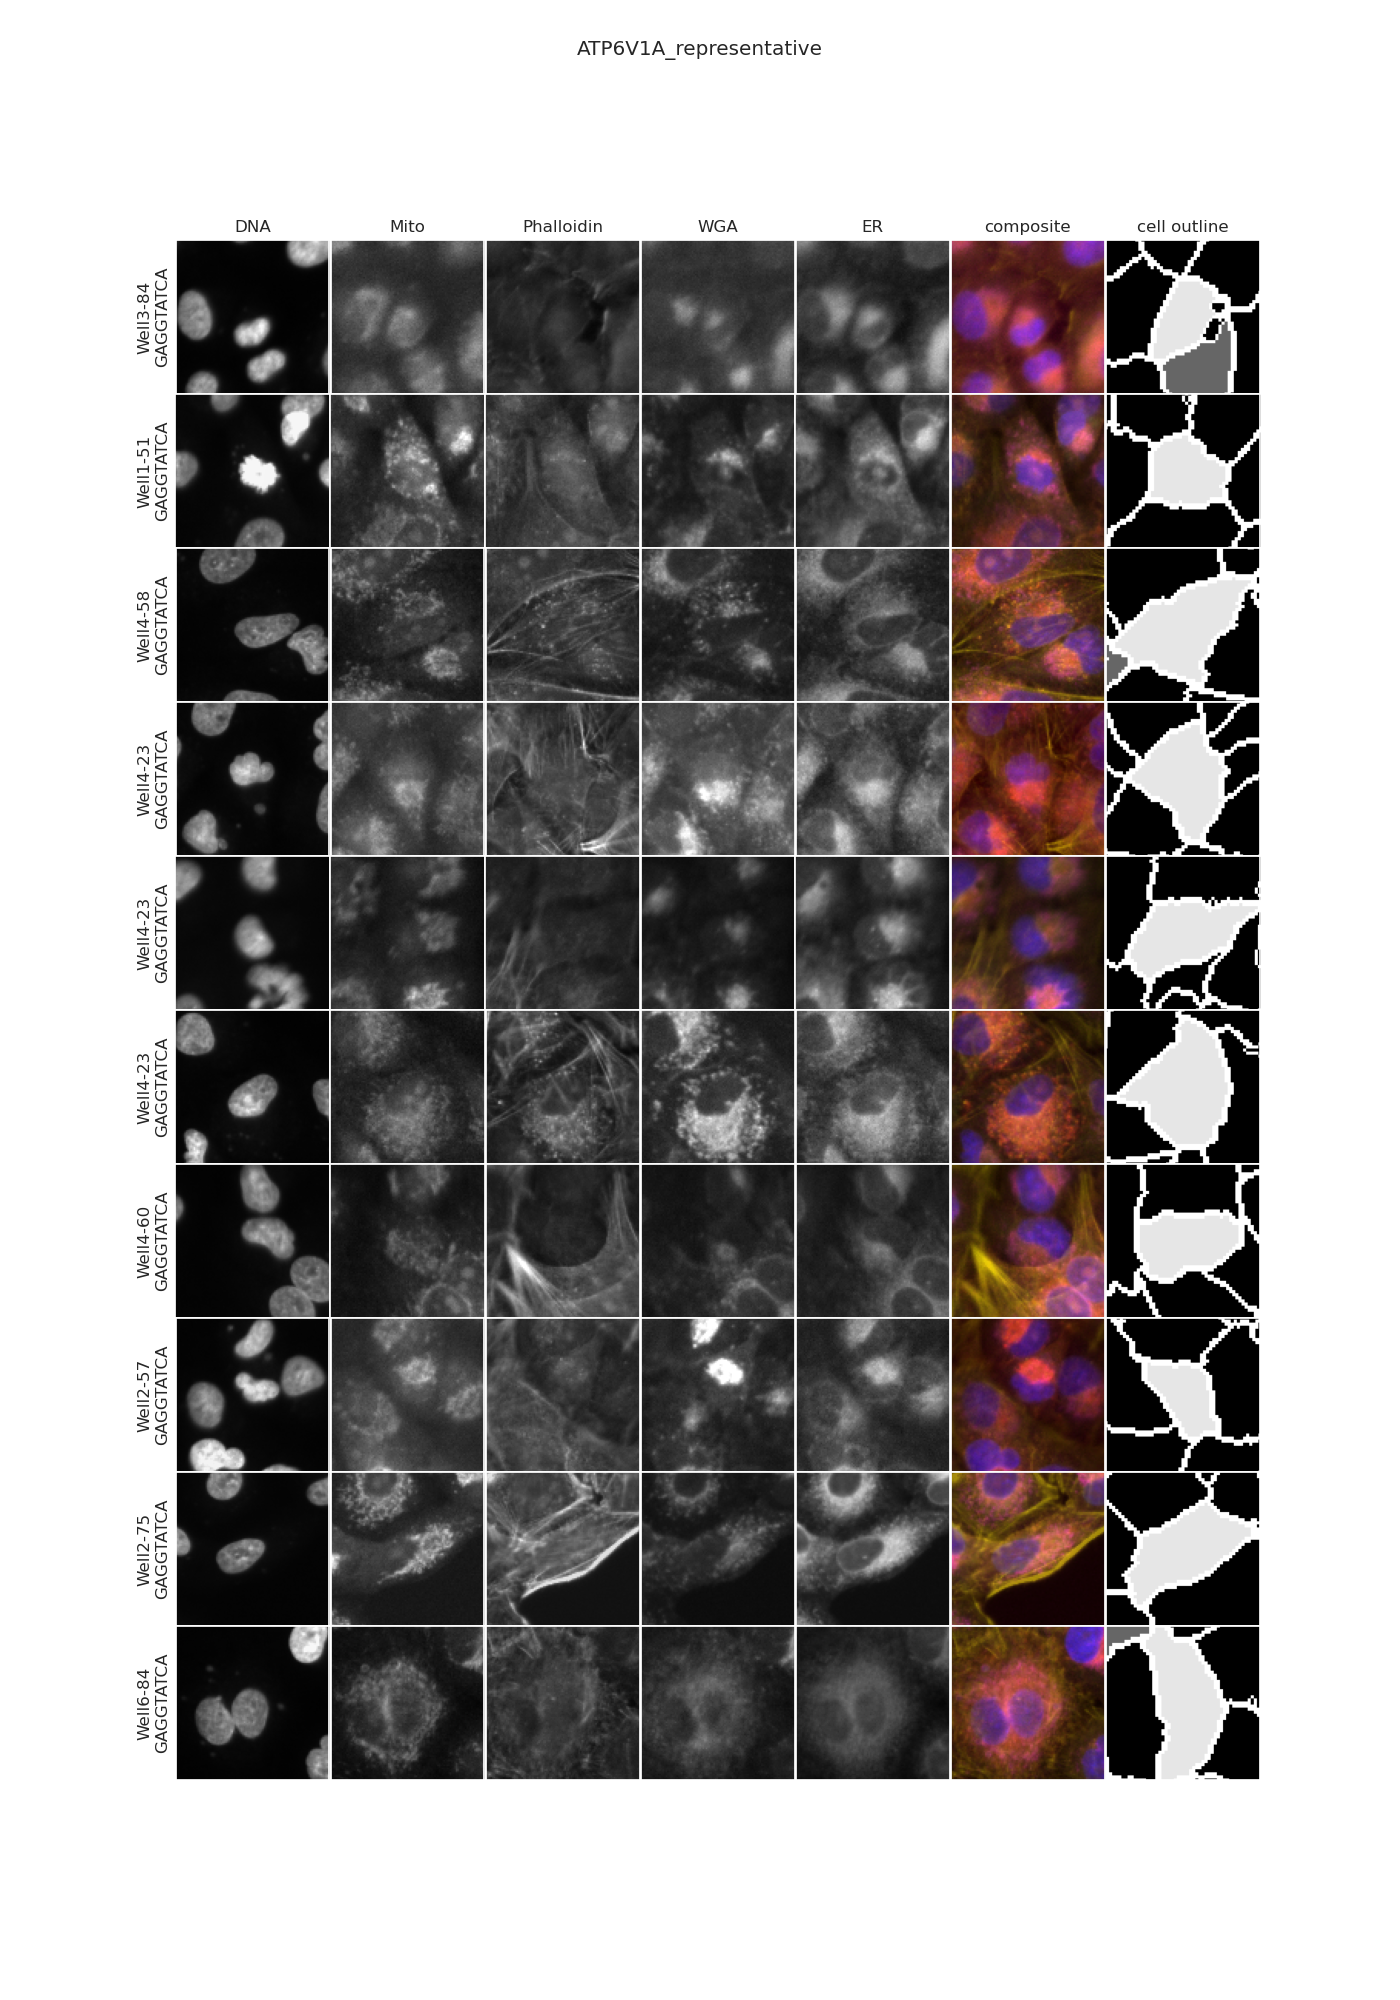

ATP6V1A_representative


In [121]:
            fig = viz_pooled.visualize_n_SingleCell_pooled(
                channels,
                df_samples,
                box_size,
                im_size,
                outline=True,
                color=True,
                title=input_gene + "_" + cell_selection_method,
                neigh_center_ls=neigh_center_ls,
            )


In [90]:
pwd

'/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis'

In [ ]:
df_samples[["Nuclei_Location_Center_X","Nuclei_Location_Center_Y"]]
# df_samples.shape,df_p_s.shape

In [49]:
# pd.concat([df_p_s, df_samples]).drop_duplicates(keep=False)["Nuclei_Location_Center_X"].shape
df_p_s.shape

(181, 3823)

In [25]:
ls /home/ubuntu/gallery/cpg0021-periscope/broad/workspace/analysis/20210422_6W_CP257/CP257K-Well3-71/

ConfluentRegions.csv*  ResizeCells.csv*      ResizeNuclei.csv*
Experiment.csv*        ResizeConfluent.csv*


In [26]:
ls /home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-71/

BarcodeFoci.csv*                  Foci.csv*              ResizeCells.csv*
Cells.csv*                        Foci_NonCellEdge.csv*  ResizeConfluent.csv*
ConfluentRegions.csv*             Foci_PreMask.csv*      Resize_Foci.csv*
CorrDNA_Site_71_Overlay.png*      heatmap/               ResizeNuclei.csv*
CorrDNA_Site_71_SpotOverlay.png*  Image.csv*             segmentation_masks/
Cytoplasm.csv*                    Nuclei.csv*
Experiment.csv*                   RelateObjects.csv*


In [19]:
import matplotlib.colors as mcolors
mcolors.to_rgb("Yellow")

(1.0, 1.0, 0.0)

In [51]:
ls /home/ubuntu/gallery/cpg0021-periscope/broad/workspace/analysis/20210422_6W_CP257/CP257K-Well2-30/

ConfluentRegions.csv*  Foci_NonCellEdge.csv*
Experiment.csv*        ResizeConfluent.csv*


In [29]:
ls /home/ubuntu/gallery/cpg0021-periscope/broad/workspace/analysis/20210422_6W_CP257/CP257K-Well2-30/

ConfluentRegions.csv*  Foci_NonCellEdge.csv*
Experiment.csv*        ResizeConfluent.csv*


In [52]:
ls /home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-30/

BarcodeFoci.csv*                  Foci.csv*              ResizeCells.csv*
Cells.csv*                        Foci_NonCellEdge.csv*  ResizeConfluent.csv*
ConfluentRegions.csv*             Foci_PreMask.csv*      Resize_Foci.csv*
CorrDNA_Site_30_Overlay.png*      heatmap/               ResizeNuclei.csv*
CorrDNA_Site_30_SpotOverlay.png*  Image.csv*             segmentation_masks/
Cytoplasm.csv*                    Nuclei.csv*
Experiment.csv*                   RelateObjects.csv*


## Visualize single cells for the input gene of guide
- Read from mounted pooled-cell-painting bucket

In [ ]:
%%time


input_matched_rows = metadata_orig[(metadata_orig['gene_symbol']==input_gene_or_guide) | (metadata_orig['sgRNA']==input_gene_or_guide)]
gene=input_matched_rows.gene_symbol.unique().tolist()[0]
guides_ls=input_matched_rows.sgRNA.unique().tolist()

all_guides_gms_ls=[]
# gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
gene_guids_ls=[sc_files_dir+batch+'_single_cell_normalized_ALLBATCHES__'+gi+'_'+gene+'.csv.gz' for gi in guides_ls]

for gi in gene_guids_ls:
    df_p_s=pd.read_csv(gi);

    for ch in channels:
        df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
        df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

    df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
    +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

    df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
    df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];

    df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);

    if df_p_s.shape[0]>0:
        df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s.sample(n = np.min([1500,df_p_s.shape[0]]),\
                        replace = False).reset_index(drop=True),n_cells,cell_selection_method);
        all_guides_gms_ls.append(df_samples)

df_p_s_all=pd.concat(all_guides_gms_ls,ignore_index=True).drop_duplicates(ignore_index=True)    

if len(gene_guids_ls)>1 and df_p_s_all.shape[0]>n_cells:
    df_samples=df_p_s_all.sample(n = np.min([n_cells,df_p_s_all.shape[0]]),replace = False).reset_index(drop=True)
    
else:
    df_samples=df_p_s_all.copy()

################  visualize cells

f=visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene_or_guide+'_'+cell_selection_method);

In [ ]:
# df_samples
# f=visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene_or_guide+'_'+cell_selection_method);

In [ ]:
np.__version__

In [ ]:
# visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=cell_selection_method);
# df_samples
# df_p_s

In [ ]:
df_p_s[df_p_s.columns[df_p_s.columns.str.contains('Alig')]]

In [ ]:
def pooled_cell_painting_single_cell_visualization(input_gene_or_guide,batch,rootDir,\
            n_cells=6,box_size=100,channels=['DNA','Mito','Phalloidin','WGA','ER','Outline'],\
                                                   cell_selection_method='random'):
    

    ########################## set directories
#     batch='20200805_A549_WG_Screen';
#     rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'
    sc_files_dir=rootDir+'workspace/software/CP186-A549-WG/data/1.profiles/20200805_A549_WG_Screen/single_cell/single_cell_by_guide/'

    im_size=5500 # hardcoded for now, TODO: create a dictionary if this number is different for 257

    ##################### read metadata and create the file name for input guide or gene
    metadata_dir=rootDir+'workspace/metadata/'+batch+'/'
    metadata_orig= pd.read_csv(metadata_dir+'Barcodes.csv')

    input_matched_rows = metadata_orig[(metadata_orig['gene_symbol']==input_gene_or_guide) | (metadata_orig['sgRNA']==input_gene_or_guide)]
    gene=input_matched_rows.gene_symbol.unique().tolist()[0]
    guides_ls=input_matched_rows.sgRNA.unique().tolist()

    all_guides_gms_ls=[]
    # gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
    gene_guids_ls=[sc_files_dir+batch+'_single_cell_normalized_ALLBATCHES__'+gi+'_'+gene+'.csv.gz' for gi in guides_ls]

    for gi in gene_guids_ls:
        df_p_s=pd.read_csv(gi);

        for ch in channels:
            df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
            df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

        df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
        +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

        df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
        df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];

        df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);

        if df_p_s.shape[0]>0:
            df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s.sample(n = np.min([1500,df_p_s.shape[0]]),\
                            replace = False).reset_index(drop=True),n_cells,cell_selection_method);
            all_guides_gms_ls.append(df_samples)

    df_p_s_all=pd.concat(all_guides_gms_ls,ignore_index=True).drop_duplicates(ignore_index=True)    

    if len(gene_guids_ls)>1 and df_p_s_all.shape[0]>n_cells:
        df_samples=df_p_s_all.sample(n = np.min([n_cells,df_p_s_all.shape[0]]),replace = False).reset_index(drop=True)

    else:
        df_samples=df_p_s_all.copy()

    ################  visualize cells

    return visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene_or_guide+'_'+cell_selection_method);


input_gene_or_guide='KRT28'
# input_gene_or_guide='GTTGAAGAGCTAGATCAACG'

batch='20200805_A549_WG_Screen';
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'

pooled_cell_painting_single_cell_visualization(input_gene_or_guide,batch,rootDir);

In [ ]:
# metadaDataFiles
# metadata_orig
# df_p_s.columns
# df_p_s[df_p_s.eq(5500).any(1)]